In [17]:
!pip install facenet-pytorch

   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
    --------------------------------------- 0.0/1.9 MB 1.9 MB/s eta 0:00:01
   ----- ---------------------------------- 0.3/1.9 MB 3.4 MB/s eta 0:00:01
   -------------- ------------------------- 0.7/1.9 MB 5.2 MB/s eta 0:00:01
   ------------------------- -------------- 1.2/1.9 MB 7.0 MB/s eta 0:00:01
   ------------------------------------- -- 1.8/1.9 MB 8.7 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 8.0 MB/s eta 0:00:00


### Import libraries as needed

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import copy

### Define helper functions

In [19]:
###########################################################################################

# Function to plot the training and validation accuracy and loss --------------------------
def plot_history(history):
    fig, axs = plt.subplots(2)

    # Create accuracy subplot
    axs[0].plot([acc.cpu().numpy() for acc in history['train_acc']], label="train accuracy")
    axs[0].plot([acc.cpu().numpy() for acc in history['val_acc']], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # Create error subplot
    axs[1].plot(history['train_loss'], label="train error")
    axs[1].plot(history['val_loss'], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Evaluation")

    plt.show()

###########################################################################################

# Function to visualize some images before you train --------------------------------------
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

############################################################################################

# Function to visualize sample count before split ------------------------------------------
def plot_class_distribution(counts, title):
    # Directly use counts.keys() if they are already class names
    labels = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(10,5))
    plt.bar(labels, values)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()


############################################################################################

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues');
    plt.ylabel('Actual Label');
    plt.xlabel('Predicted Label');
    plt.title('Confusion Matrix', size=15);
    plt.show()

############################################################################################

# Function for classification report for perfomance metrics
from sklearn import preprocessing
def calculate_metrics(y_true, y_pred):
    le = preprocessing.LabelEncoder()
    le.fit(y_true)
    class_names = [str(cls) for cls in le.classes_]
    print(classification_report(y_true, y_pred, target_names=class_names))

############################################################################################


### Define function to **train** the model

In [6]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize the history
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Initialize variables for early stopping
    num_epochs_no_improvement = 0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # if phase == 'Train':
            #     scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Validation':
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f'bestmodel_inceptresnet_balanced.pth')
                    num_epochs_no_improvement = 0
                else:
                    num_epochs_no_improvement += 1

            # Save the loss and accuracy in history
            if phase == 'Train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

        print()

        # Early stopping
        if num_epochs_no_improvement >= patience:
            print('No improvement in validation accuracy for {} epochs, stopping early.'.format(patience))
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


### Load data, setup dataloaders, and visualize sample counts

Add balancing to data set using Data Augmentation and oversampling classes

In [39]:
# Custom Dataset for Balancing Classes with Augmentation
class BalancedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        self.indices = self._balance_classes(dataset)

    def _balance_classes(self, dataset):
        class_counts = dict(Counter(dataset.targets))
        max_count = max(class_counts.values())
        class_indices = [np.where(np.array(dataset.targets) == class_id)[0] for class_id in class_counts]
        balanced_indices = [np.random.choice(indices, max_count, replace=True).tolist() for indices in class_indices]
        return [idx for indices in balanced_indices for idx in indices]

    def __getitem__(self, index):
        img, label = self.dataset[self.indices[index]]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.indices)

In [40]:
# Define your transformations
# Transformation with augmentation for training data
balanced_train_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformation without augmentation for validation and testing data
val_test_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dir = 'C:/Users/Anish Patel/Desktop/ENSF645 Final Project/Dataset/train'
test_dir = 'C:/Users/Anish Patel/Desktop/ENSF645 Final Project/Dataset/test'

# Load the datasets
train_data = datasets.ImageFolder(train_dir)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Applying the BalancedDataset wrapper to the training dataset
balanced_train_data = BalancedDataset(train_data, balanced_train_transform)

# Get the class names
class_names_train = test_data.classes
class_names_test = test_data.classes

# Create a dictionary mapping indices to class names
idx_to_class_train = {i: class_name for i, class_name in enumerate(class_names_train)}
idx_to_class_test = {i: class_name for i, class_name in enumerate(class_names_test)}

# Count labels in the original dataset for train and test
test_counts = Counter(test_data.targets)
balanced_train_counts = Counter()

# Iterate through the balanced indices to count each label
for idx in balanced_train_data.indices:
    # Get the label from the original dataset using the balanced index
    label = balanced_train_data.dataset.targets[idx]
    balanced_train_counts[label] += 1

# Map the counted indices back to class names using idx_to_class_train
balanced_train_counts_mapped = {idx_to_class_train[idx]: count for idx, count in balanced_train_counts.items()}

# Print the counts for each class
print("Balanced Train Counts:", balanced_train_counts_mapped)
print("Test Counts:", {idx_to_class_test[i]: count for i, count in test_counts.items()})

Balanced Train Counts: {'angry': 7215, 'fear': 7215, 'happy': 7215, 'sad': 7215, 'surprise': 7215}
Test Counts: {'angry': 958, 'fear': 1024, 'happy': 1774, 'sad': 1247, 'surprise': 831}


Now the classes in the `Train` set are all balanced. We keep the test set the same as it should be original data to test on

In [41]:
# Get the indices of the samples in the validation and test sets
test_indices = [i for i, (img_path, _) in enumerate(test_data.imgs) if 'Private' in img_path]
valid_indices = [i for i, (img_path, _) in enumerate(test_data.imgs) if 'Private' not in img_path]

# Create subset datasets
validation_data = torch.utils.data.Subset(test_data, valid_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)

# Create data loaders
batch_size = 64
num_workers = 4
train_loader = DataLoader(balanced_train_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataloaders = {
    'Train': train_loader,
    'Validation': validation_loader,
    'Test': test_loader
}

In [42]:
print("Length of Train Loader: ", len(dataloaders['Train']))
print("Length of Validation Loader: ", len(dataloaders['Validation']))

Length of Train Loader:  564
Length of Validation Loader:  46


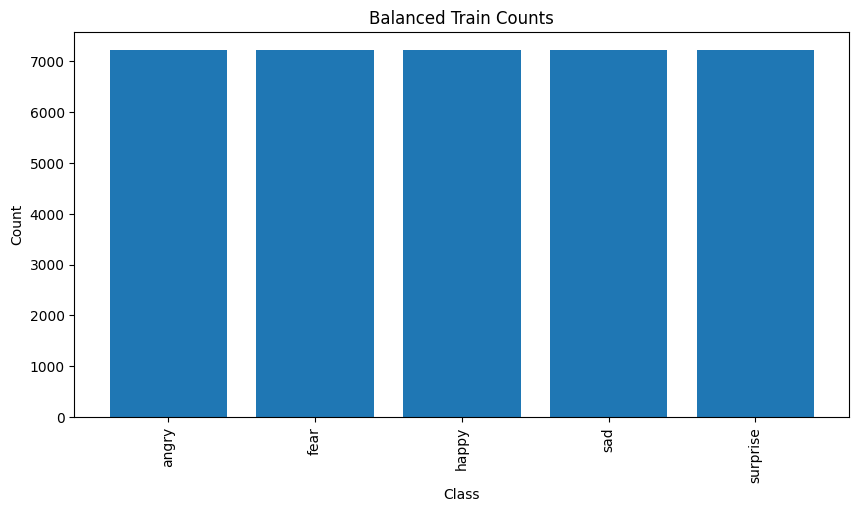

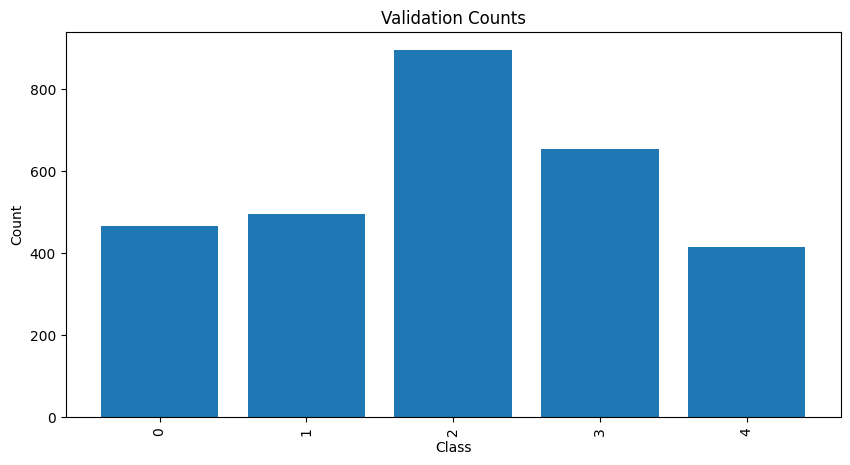

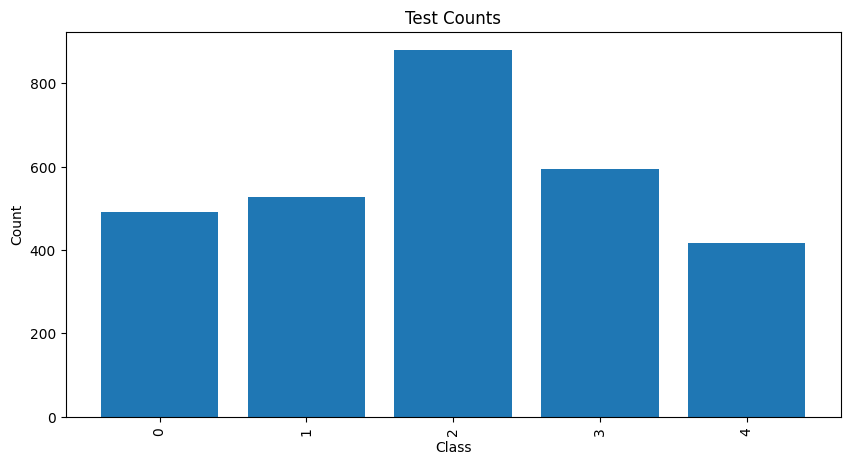

In [43]:
# Get the class names
class_names = train_data.classes

# Create a dictionary mapping indices to class names
idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}

# Use balanced_train_counts_mapped for balanced train counts
balanced_train_counts_mapped = {idx_to_class[idx]: count for idx, count in balanced_train_counts.items()}

# Count labels in the subsets
valid_counts = Counter(test_data.dataset.targets[i] for i in valid_indices)
test_counts = Counter(test_data.dataset.targets[i] for i in test_indices)

# Plot
plot_class_distribution(balanced_train_counts_mapped, 'Balanced Train Counts')
plot_class_distribution(valid_counts, 'Validation Counts')
plot_class_distribution(test_counts, 'Test Counts')

As seen the data in train is balanced. 

**0: Angry**
**1: Fear**
**2: Happy**
**3: Sad**
**4: Surprise**

### Visualize some sample from the training set before training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


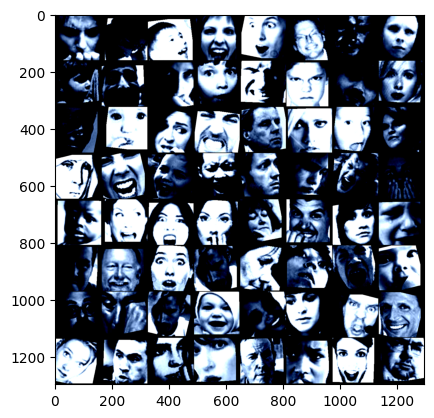

In [44]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

### Import ResNet50 model and freeze layers + replace classifier to match our number of classes and some basic fc layers with ReLU and end with a softmax activation

In [45]:
from facenet_pytorch import InceptionResnetV1

class TransferVGGFace2(nn.Module):
    def __init__(self, num_classes=5, freeze_features=True, unfreeze_blocks=None):
        super(TransferVGGFace2, self).__init__()
        
        # Load the InceptionResnetV1 model pre-trained on VGGFace2
        self.base_model = InceptionResnetV1(pretrained='vggface2').eval()

        # Output features of the base_model
        self.output_features = self.base_model.last_linear.in_features

        if freeze_features:
            # Freeze all parameters in the base model
            for param in self.base_model.parameters():
                param.requires_grad = False

            # Optionally unfreeze some of the later blocks for fine-tuning
            if unfreeze_blocks:
                for name, child in self.base_model.named_children():
                    if name in unfreeze_blocks:
                        for param in child.parameters():
                            param.requires_grad = True

        # Remove the last layers of the base model
        self.base_model.logits = nn.Identity()
        self.base_model.last_bn = nn.Identity()
        self.base_model.last_linear = nn.Identity()

        # New classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.output_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Extract features using the base model
        x = self.base_model(x)

        # Flatten and pass through the new classifier
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the model with the option to unfreeze blocks
model = TransferVGGFace2(num_classes=5, freeze_features=True, unfreeze_blocks=['repeat_2', 'block8'])

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

if torch.cuda.is_available():
    print("Using GPU")
else:
    print("Using CPU")

print(model)


c:\Users\Anish Patel\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU
TransferVGGFace2(
  (base_model): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=

Define loss function, step optimizer, learning rate scheduler

In [46]:
# Define the criterion
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss() # try this first

# Define the optimizer (only the parameters of the classifier will be optimized)
# optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam([
    {'params': model.base_model.parameters(), 'lr': 1e-4, 'weight_decay': 1e-4},
    {'params': model.base_model.last_linear.parameters(), 'lr': 1e-3}
])

# Define the learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

### Train the model

In [47]:
model, history = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=35)

Epoch 0/34
----------
Train Loss: 1.5552 Acc: 0.5557
Validation Loss: 1.4976 Acc: 0.6668

Epoch 1/34
----------
Train Loss: 1.5340 Acc: 0.6813
Validation Loss: 1.4898 Acc: 0.6924

Epoch 2/34
----------
Train Loss: 1.5294 Acc: 0.7143
Validation Loss: 1.4900 Acc: 0.6808

Epoch 3/34
----------
Train Loss: 1.5263 Acc: 0.7382
Validation Loss: 1.4853 Acc: 0.7033

Epoch 4/34
----------
Train Loss: 1.5240 Acc: 0.7537
Validation Loss: 1.4859 Acc: 0.7075

Epoch 5/34
----------
Train Loss: 1.5213 Acc: 0.7766
Validation Loss: 1.4856 Acc: 0.7109

Epoch 6/34
----------
Train Loss: 1.5196 Acc: 0.7884
Validation Loss: 1.4860 Acc: 0.7078

Epoch 7/34
----------
Train Loss: 1.5184 Acc: 0.8010
Validation Loss: 1.4896 Acc: 0.6948

Epoch 8/34
----------
Train Loss: 1.5172 Acc: 0.8105
Validation Loss: 1.4886 Acc: 0.6982

Epoch 9/34
----------
Train Loss: 1.5163 Acc: 0.8190
Validation Loss: 1.4894 Acc: 0.6999

Epoch 10/34
----------
Train Loss: 1.5114 Acc: 0.8568
Validation Loss: 1.4825 Acc: 0.7276

Epoch 11/

### Plot the loss and accuracy values during training for the train and validation sets

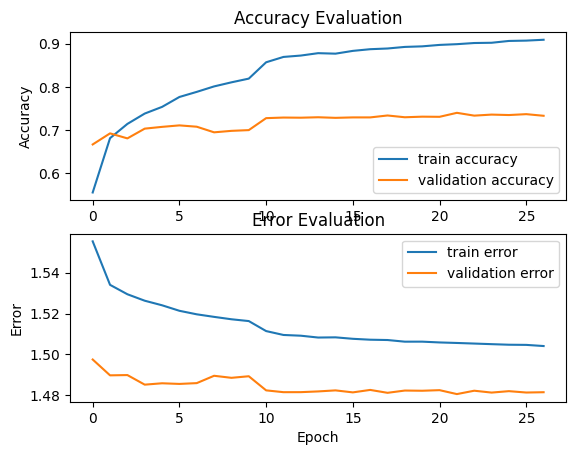

In [52]:
# Plot the history
plot_history(history)

### Plot performance metrics such as accuracy, precision, recall and f1-score as well as the **Confusion Matrix**

In [49]:
# Get predictions for the test set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [53]:
# Calculate metrics
calculate_metrics(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.65      0.62      0.64       491
           1       0.57      0.49      0.53       528
           2       0.92      0.90      0.91       879
           3       0.62      0.72      0.67       594
           4       0.79      0.82      0.80       416

    accuracy                           0.73      2908
   macro avg       0.71      0.71      0.71      2908
weighted avg       0.73      0.73      0.73      2908



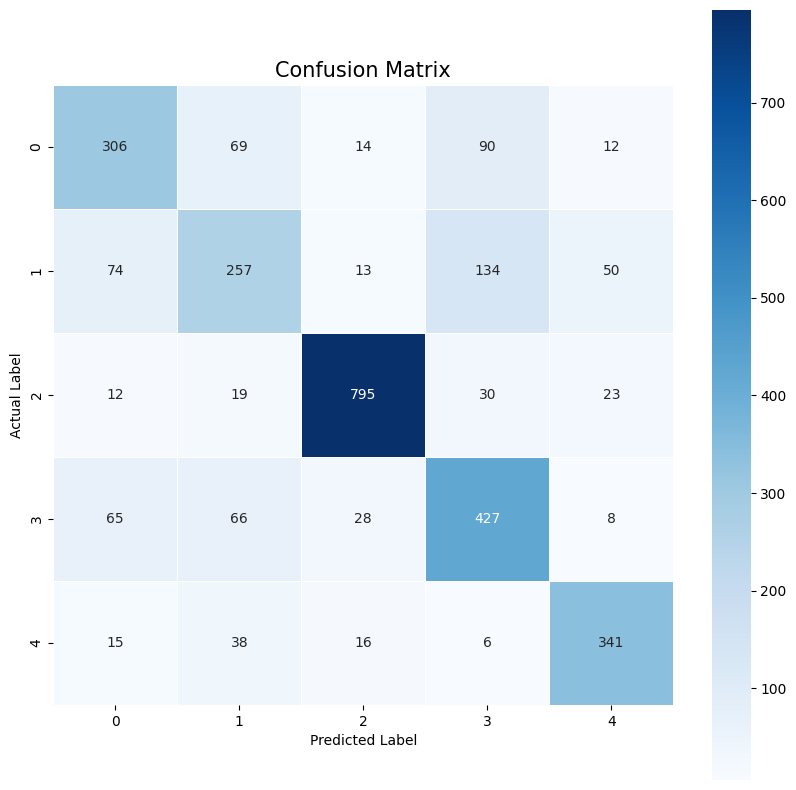

In [51]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)